Reference- https://www.analyticsvidhya.com/blog/2017/12/introduction-to-recurrent-neural-networks/

http://karpathy.github.io/2015/05/21/rnn-effectiveness/



Running preprocessing and loading data
First preprocess your downloaded corpus (see above) with the helper file (also see above).

python prepare_data.py shakespeare.txt skp (with skp being how you like to call the output files).
In the jupyter environment (assuming you’re in the right working directory) you can run !python prepare_data.py shakespeare.txt skp.
(you can change the sequence length with an additional -l argument)
Preprocessing creates a skp.tfrecords file (the data, not human-readable) and a skp_vocab file (the vocabulary, pickle serialized, not human-readable). You will use those files to train your RNN.
Loading is done like this:

In [ ]:
import tensorflow as tf
import numpy as np
import keras


In [ ]:
!python prepare_data.py shk_input.txt skp 

2020-11-27 19:28:58.097588: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Split input into 5604 sequences...
Serialized 100 sequences...
Serialized 200 sequences...
Serialized 300 sequences...
Serialized 400 sequences...
Serialized 500 sequences...
Serialized 600 sequences...
Serialized 700 sequences...
Serialized 800 sequences...
Serialized 900 sequences...
Serialized 1000 sequences...
Serialized 1100 sequences...
Serialized 1200 sequences...
Serialized 1300 sequences...
Serialized 1400 sequences...
Serialized 1500 sequences...
Serialized 1600 sequences...
Serialized 1700 sequences...
Serialized 1800 sequences...
Serialized 1900 sequences...
Serialized 2000 sequences...
Serialized 2100 sequences...
Serialized 2200 sequences...
Serialized 2300 sequences...
Serialized 2400 sequences...
Serialized 2500 sequences...
Serialized 2600 sequences...
Serialized 2700 sequences...
Serialized 2800 sequences...
Serialized 2900 

In [ ]:
#Getting the data
from prepare_data import parse_seq
import pickle

# this is just a datasets of "bytes" (not understandable)
data = tf.data.TFRecordDataset("skp.tfrecords")

# this maps a parser function that properly interprets the bytes over the dataset
# (with fixed sequence length 200)
# if you change the sequence length in preprocessing you also need to change it here
data = data.map(lambda x: parse_seq(x, 200))

# a map from characters to indices
vocab = pickle.load(open("skp_vocab", mode="rb"))
vocab_size = len(vocab)
# inverse mapping: indices to characters
ind_to_ch = {ind: ch for (ch, ind) in vocab.items()}

print(vocab)
print(vocab_size)

{'w': 1, 'Q': 2, 'c': 3, 'Y': 4, 'f': 5, 'k': 6, 'T': 7, 'E': 8, 'd': 9, 'j': 10, '-': 11, 'i': 12, 'o': 13, '\n': 14, 'H': 15, 'a': 16, 'p': 17, '.': 18, 'I': 19, 'r': 20, 'W': 21, 'q': 22, '?': 23, 'g': 24, 'x': 25, 'y': 26, 'R': 27, ' ': 28, 'J': 29, '3': 30, 'O': 31, ';': 32, 'K': 33, ':': 34, 'A': 35, 'L': 36, '&': 37, 'Z': 38, 'v': 39, 'l': 40, 'b': 41, "'": 42, 'e': 43, 'N': 44, 'u': 45, 'B': 46, 'h': 47, 'P': 48, 'F': 49, 'S': 50, '!': 51, 't': 52, 'n': 53, 'X': 54, 's': 55, 'U': 56, '$': 57, 'm': 58, 'D': 59, 'C': 60, 'V': 61, 'G': 62, 'z': 63, 'M': 64, ',': 65, '<S>': 0}
66


Expand your data from indices into one-hot vectors (tf.one_hot()). The necessary depth is the vocab_size we already obtained from the vocabulary file. Your input is turned from batch_size x seq_len into batch_size x seq_len x vocab_size.

Reference- https://www.tensorflow.org/api_docs/python/tf/one_hot

In [ ]:
#one hot encoding

def hotcoding(input_data):
  
  one_hot_coded_data = tf.one_hot(indices = input_data, depth = vocab_size)
  return one_hot_coded_data;

one_hot_coded_data = data.map(hotcoding)

#batching

one_hot_coded_data_batch = one_hot_coded_data.batch(128)

one_hot_coded_data_batch



<BatchDataset shapes: (None, 200, 66), types: tf.float32>

Set up the variables for computing one time step of the RNN. In our case each time step processes one character. You will need weights/biases to go from input to hidden, hidden to hidden and hidden to output. You also need to set up an initial state – this could be a constant (e.g. all zeros) or another trainable variable. Food for thought: Given that the data processing adds a “beginning of sequence” character to all sequences, is there any use for a trainable initial state?

In [ ]:
# weights and bias
#input = vocab size,
#hidden units = 512 
#input to hidden
h_o = tf.Variable(np.random.uniform(-0.1, 0.1, [1,512]).astype(np.float32),name='1')
w_xh = tf.Variable(np.random.uniform(-0.1, 0.1, [66, 512]).astype(np.float32),name='2')
#hidden to hidden
w_hh = tf.Variable(np.random.uniform(-0.1, 0.1, [512,512]).astype(np.float32),name='3')
b_h = tf.Variable(np.random.uniform(-0.1, 0.1, [512]).astype(np.float32),name='4')
#hidden to output
w_ho = tf.Variable(np.random.uniform(-0.1, 0.1, [66,512]).astype(np.float32),name='5')
b_o = tf.Variable(np.random.uniform(-0.1, 0.1, [66]).astype(np.float32),name='6')


In [ ]:
h_o.shape,w_xh.shape, w_xh.shape, b_h.shape, w_ho.shape, b_o.shape

(TensorShape([1, 512]),
 TensorShape([66, 512]),
 TensorShape([66, 512]),
 TensorShape([512]),
 TensorShape([66, 512]),
 TensorShape([66]))

In [ ]:
param = [w_xh,w_hh, b_h, w_ho, b_o]

In preprocessing it might just be telling that a new line or para is staring but for traiing initial state, it might be start of a word and it might not always be newline or static for all. like "Chapert 1" can be beigiing so its useful to use this as inital traninable state.

Iterate over the time axis of your input (simply with a Python for-loop) and do the RNN computations for each step: Compute the new state given the old state and the current input, and from this compute the output (logits). Question: What’s the difference between for time_step in range(n_time_steps) and for time_step in tf.range(n_time_steps)?

Also, you need to use tf.range to query the shape at run time.
Reference- https://stackoverflow.com/questions/43126116/range-of-size-of-tensors-dimension-tf-range

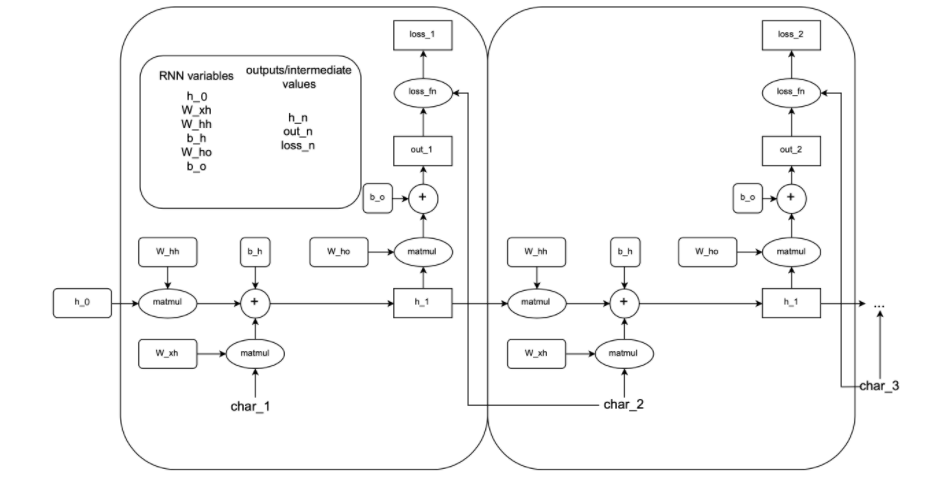

In [ ]:
#convert it into a fucntion?
#just copying as per the above diagram, operation by opeartion
def compute_loss_char_by_char(h_n, char1, char2):
  xh_matmul = tf.matmul(char1, w_xh) 
  whh_matmul = tf.matmul(h_n, w_hh) 
  add1 = b_h+whh_matmul+xh_matmul
  add1 = tf.nn.tanh(add1)
  w_ho_matmul = tf.matmul(add1,tf.reshape(w_ho, shape=(512,66)))
  add2 = tf.add(w_ho_matmul,tf.reshape(b_o, shape=(1, vocab_size)))
  out_1 = add2 #prediction by the calculation
  expected_word = char2 #word which should be next
  loss = tf.nn.softmax_cross_entropy_with_logits(labels = expected_word, logits = out_1) #diff between two

  return  loss , add1 , out_1

#going it thorugh the whole input

#losses
opt = keras.optimizers.Adam()
print("Done")

Done


In [ ]:
#running it
epoch = 20

for e in range(epoch):
  for batch_num, batch_data in enumerate(one_hot_coded_data_batch): #this is already batched of 128 batch size
    total_loss = 0.0 #total loss over sequence 
    
    with tf.GradientTape(persistent=True) as tape:
      for t in range(199): #goign over the sequence in each batch
        if t==0: #if first character
          h_n = h_o #then take value as initialised above 
          char1  = batch_data[:,t] # at time stamp t
          char2 = batch_data[:,t+1] # at time stamp t+1 , the charcter we want the before one to predict
          loss , h_n , o = compute_loss_char_by_char(h_n,char1, char2) #calling computation and getting loss for each charcter in sequence
          
        else:
          char1  = batch_data[:,t]
          char2 = batch_data[:,t+1]
          loss , h_n , o = compute_loss_char_by_char(h_n,char1, char2)
          
        total_loss += loss #sum of all of losses over each charcter in sequence since weights are not chaning, summing like good option
        
    grads = tape.gradient(total_loss, param) #gradients against the parametes/weights and biasas
    opt.apply_gradients(zip(grads, param))
    #print("total_loss from inner") #it showed 128 shape of total loss
    #print(total_loss)
    total_loss = float(tf.reduce_mean(total_loss)/200) # this is total loss over the whole batch
    if batch_num % 20 == 0:
          print('Epoch {} Batch {} Loss {}'.format(e, batch_num, total_loss))
print('Epoch {} Loss {:.4f}'.format(e, total_loss))



  

Epoch 0 Batch 0 Loss 4.354370594024658
Epoch 0 Batch 20 Loss 3.295933723449707
Epoch 0 Batch 40 Loss 3.2661032676696777
Epoch 1 Batch 0 Loss 3.227954387664795
Epoch 1 Batch 20 Loss 3.1483168601989746
Epoch 1 Batch 40 Loss 3.1229124069213867
Epoch 2 Batch 0 Loss 3.0633978843688965
Epoch 2 Batch 20 Loss 2.9944498538970947
Epoch 2 Batch 40 Loss 2.909177780151367
Epoch 3 Batch 0 Loss 2.834954023361206
Epoch 3 Batch 20 Loss 2.7482690811157227
Epoch 3 Batch 40 Loss 2.6386477947235107
Epoch 4 Batch 0 Loss 2.6261701583862305
Epoch 4 Batch 20 Loss 2.5846762657165527
Epoch 4 Batch 40 Loss 2.5148401260375977
Epoch 5 Batch 0 Loss 2.521864414215088
Epoch 5 Batch 20 Loss 2.4704344272613525
Epoch 5 Batch 40 Loss 2.409804105758667
Epoch 6 Batch 0 Loss 2.4256467819213867
Epoch 6 Batch 20 Loss 2.3969788551330566
Epoch 6 Batch 40 Loss 2.3560640811920166
Epoch 7 Batch 0 Loss 2.3517072200775146
Epoch 7 Batch 20 Loss 2.3377835750579834
Epoch 7 Batch 40 Loss 2.3616745471954346
Epoch 8 Batch 0 Loss 2.34915041

Generating Language
Having trained an RNN, you can use it to generate language – technically, you’re “sampling from the language model”. To do this, you should:

Extend your RNN with a softmax output activation applied to the logits so that it outputs probability distributions.

Done

Generate a probability distribution over the next character. Feed as input the last character as well as the current state. To start this process, the “last” character should be (the beginning-of-sequence character inserted when creating the dataset) and the “last state” whatever you chose as initial state. Make sure to output the resulting state along with the probabilities so you can feed it into the network for the next step.


Sample from the probability distribution (e.g. using np.random.choice) (Food for thought: Could you also use argmax?). This will give you an index that you can feed back as input into the network for the next step. Also, you can map this to a character using the vocabulary file.
Repeat this process for as long as you want, maybe for several hundred characters. Join all the characters into a single string and look at your output. Note that even if your network was only trained on sequences of a certain length, you can keep this process going for much longer – although your network might not be able to handle it.


Assuming your network was trained properly and your generation process works, the output should at least superficially resemble the training data. For example, in the case of Shakespeare you should see a dialogue structure with proper use of newlines and whitespace. Depending on how long you trained, the text itself should hopefully “look like” English, although there will likely be plenty of fantasy words. This is not a problem per se – chances are the task is just too difficult for this simple network. Still, if your output looks completely jumbled, there is probably something wrong with your generation process.

In [ ]:
#predicting part

char1 = input()
char1 = vocab[char1] #from the vocab

print(char1)

w
1


In [ ]:
#[w_xh, w_xh, b_h, w_ho, b_o] #tranied variables

char1_encoded = hotcoding(char1)
char1_encoded




<tf.Tensor: shape=(66,), dtype=float32, numpy=
array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
last_state = input()
last_state_encoded = hotcoding(last_state)
last_state_encoded

In [ ]:
loss, add1, out = compute_loss_char_by_char(h_o, tf.reshape(char1_encoded, shape=(1, 66)), char1_encoded)
out

<tf.Tensor: shape=(1, 66), dtype=float32, numpy=
array([[-0.91116244, -0.7536258 , -0.71655893, -1.4375856 , -1.8205993 ,
        -1.2133796 , -1.5879858 , -1.3984404 , -1.0496955 , -1.7080628 ,
        -1.0347744 , -0.13180265,  3.2139623 ,  1.7313734 ,  0.9862635 ,
        -1.3369979 ,  2.2112937 , -1.4947228 ,  0.35056615, -0.1626996 ,
         0.49147964, -1.6310958 , -1.118969  , -0.37415272, -1.412233  ,
        -1.6887059 , -0.6709322 , -1.0197273 ,  1.4808899 , -0.8192471 ,
        -1.4138656 , -0.7146744 ,  0.21127743, -1.5162652 ,  0.34518656,
        -0.49231064, -1.3002083 , -1.1033156 , -1.4912544 , -1.0528797 ,
        -1.0224866 , -1.4322342 ,  0.07096824,  2.8397536 , -1.6965147 ,
        -0.01443727, -1.3727713 ,  3.8114522 , -1.3175691 , -1.360377  ,
        -1.6396366 ,  0.10641515, -0.36477953,  1.7730571 , -0.8554213 ,
         0.34535968, -1.180747  , -1.4604169 , -1.2215654 , -1.5253352 ,
        -1.9698427 , -0.89154536, -1.3784763 , -1.8953044 , -1.997653  ,
  

In [ ]:
prob_out = tf.nn.softmax(out)
prob_out

<tf.Tensor: shape=(1, 66), dtype=float32, numpy=
array([[0.00279371, 0.00327038, 0.00339388, 0.00165028, 0.00112517,
        0.00206505, 0.00141984, 0.00171617, 0.0024323 , 0.00125919,
        0.00246886, 0.0060905 , 0.1728622 , 0.03924822, 0.01863042,
        0.00182492, 0.06342297, 0.00155863, 0.00986604, 0.0059052 ,
        0.01135902, 0.00135993, 0.00226951, 0.00477971, 0.00169266,
        0.0012838 , 0.00355232, 0.00250629, 0.03055176, 0.00306266,
        0.0016899 , 0.00340028, 0.00858323, 0.00152542, 0.00981311,
        0.00424704, 0.00189331, 0.00230531, 0.00156405, 0.00242457,
        0.00249939, 0.00165914, 0.00745959, 0.11890039, 0.00127382,
        0.00684895, 0.00176079, 0.31418583, 0.00186072, 0.00178275,
        0.00134837, 0.00772875, 0.00482472, 0.0409188 , 0.00295386,
        0.00981481, 0.00213355, 0.00161303, 0.00204821, 0.00151164,
        0.00096917, 0.00284905, 0.00175077, 0.00104418, 0.00094259,
        0.01644944]], dtype=float32)>

In [ ]:
index = np.random.choice(a=vocab_size, size=1, p=prob_out.numpy()[0])
for char in vocab.keys():
  if vocab[char] == index:
    output_string += char
print(output_string)

teHtejptPepjtiGlhuitteattictettboIcetaeTcJ.eQQheiahpaecj':UIawekCahMttAhiiiutetv? dtuchebwtiha ih 'fuototte.hRuetttttraawbpt;QtpwM'ed,tpttehoocfwhaiecEoQufYeotehiIapeheytohoiIkmtePeeghttVtdyyhgttaxjiAiRJieiaiSnt:t;ptttpppeuae eaoYtuvte,hpYttNpt
YaawAottrieDeepFe ttttttttttttttttttttttttttttttttttttttttttttttttttiuktyEvepjetttesreuRthcH-O
eipGhiteUtoIOeteSeecptt,be?to;etJJyethaeeXkhSwcey'cttbi?epciYitpeIeihyatwtttttttttttttttttttttttttttttttttttttttttttttttttttehputteckEctLEttgk<S>vEaIeteqttueetelWtiYuYtcoQtctdiaecehRttotppotcehhEcotcAYgcacttAmO
t!tfROUe!Fceoup&peb,htH'otEe3Yheoptcett TtktcayeIeiceItqqpthe&eti oetSctEcejhhyaAYaFptOcQhIgpwisDiahnE,tahwgtcpRepoctsaep;etQartejebzckyPt
tepcy:ecQoweeCmptt,tceieeaABRpituwa abweicvptectoeywYt oec!titeOWi tieti?ettIrHpapcYhhttieitae$checeee t Nete:eue'yFet aqtgQe iuyecptcCftihipcacute,thqoertyactipttZ?hi,bjoep'tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

In [ ]:
#trying with argmax
index = int(tf.math.argmax(prob_out[0]))
for char in vocab.keys():
  if vocab[char] == index:
    output_string += char
print(output_string)

teHtejptPepjtiGlhuitteattictettboIcetaeTcJ.eQQheiahpaecj':UIawekCahMttAhiiiutetv? dtuchebwtiha ih 'fuototte.hRuetttttraawbpt;QtpwM'ed,tpttehoocfwhaiecEoQufYeotehiIapeheytohoiIkmtePeeghttVtdyyhgttaxjiAiRJieiaiSnt:t;ptttpppeuae eaoYtuvte,hpYttNpt
YaawAottrieDeepFe ttttttttttttttttttttttttttttttttttttttttttttttttttiuktyEvepjetttesreuRthcH-O
eipGhiteUtoIOeteSeecptt,be?to;etJJyethaeeXkhSwcey'cttbi?epciYitpeIeihyatwtttttttttttttttttttttttttttttttttttttttttttttttttttehputteckEctLEttgk<S>vEaIeteqttueetelWtiYuYtcoQtctdiaecehRttotppotcehhEcotcAYgcacttAmO
t!tfROUe!Fceoup&peb,htH'otEe3Yheoptcett TtktcayeIeiceItqqpthe&eti oetSctEcejhhyaAYaFptOcQhIgpwisDiahnE,tahwgtcpRepoctsaep;etQartejebzckyPt
tepcy:ecQoweeCmptt,tceieeaABRpituwa abweicvptectoeywYt oec!titeOWi tieti?ettIrHpapcYhhttieitae$checeee t Nete:eue'yFet aqtgQe iuyecptcCftihipcacute,thqoertyactipttZ?hi,bjoep'tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

In [ ]:
#may be trying running it over more sequence?
for i in range(400):
  index = np.random.choice(a=vocab_size, size=1, p=prob_out.numpy()[0])
  char = index
  for char in vocab.keys():
    if vocab[char] == index:
      output_string += char
print(output_string)


teHtejptPepjtiGlhuitteattictettboIcetaeTcJ.eQQheiahpaecj':UIawekCahMttAhiiiutetv? dtuchebwtiha ih 'fuototte.hRuetttttraawbpt;QtpwM'ed,tpttehoocfwhaiecEoQufYeotehiIapeheytohoiIkmtePeeghttVtdyyhgttaxjiAiRJieiaiSnt:t;ptttpppeuae eaoYtuvte,hpYttNpt
YaawAottrieDeepFe ttttttttttttttttttttttttttttttttttttttttttttttttttiuktyEvepjetttesreuRthcH-O
eipGhiteUtoIOeteSeecptt,be?to;etJJyethaeeXkhSwcey'cttbi?epciYitpeIeihyatwtttttttttttttttttttttttttttttttttttttttttttttttttttehputteckEctLEttgk<S>vEaIeteqttueetelWtiYuYtcoQtctdiaecehRttotppotcehhEcotcAYgcacttAmO
t!tfROUe!Fceoup&peb,htH'otEe3Yheoptcett TtktcayeIeiceItqqpthe&eti oetSctEcejhhyaAYaFptOcQhIgpwisDiahnE,tahwgtcpRepoctsaep;etQartejebzckyPt
tepcy:ecQoweeCmptt,tceieeaABRpituwa abweicvptectoeywYt oec!titeOWi tieti?ettIrHpapcYhhttieitae$checeee t Nete:eue'yFet aqtgQe iuyecptcCftihipcacute,thqoertyactipttZ?hi,bjoep'tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

In [ ]:
#may be trying running it over more sequence?
for i in range(400):
  index = int(tf.math.argmax(prob_out[0]))
  for char in vocab.keys():
    if vocab[char] == index:
      output_string += char
print(output_string)

teHtejptPepjtiGlhuitteattictettboIcetaeTcJ.eQQheiahpaecj':UIawekCahMttAhiiiutetv? dtuchebwtiha ih 'fuototte.hRuetttttraawbpt;QtpwM'ed,tpttehoocfwhaiecEoQufYeotehiIapeheytohoiIkmtePeeghttVtdyyhgttaxjiAiRJieiaiSnt:t;ptttpppeuae eaoYtuvte,hpYttNpt
YaawAottrieDeepFe ttttttttttttttttttttttttttttttttttttttttttttttttttiuktyEvepjetttesreuRthcH-O
eipGhiteUtoIOeteSeecptt,be?to;etJJyethaeeXkhSwcey'cttbi?epciYitpeIeihyatwtttttttttttttttttttttttttttttttttttttttttttttttttttehputteckEctLEttgk<S>vEaIeteqttueetelWtiYuYtcoQtctdiaecehRttotppotcehhEcotcAYgcacttAmO
t!tfROUe!Fceoup&peb,htH'otEe3Yheoptcett TtktcayeIeiceItqqpthe&eti oetSctEcejhhyaAYaFptOcQhIgpwisDiahnE,tahwgtcpRepoctsaep;etQartejebzckyPt
tepcy:ecQoweeCmptt,tceieeaABRpituwa abweicvptectoeywYt oec!titeOWi tieti?ettIrHpapcYhhttieitae$checeee t Nete:eue'yFet aqtgQe iuyecptcCftihipcacute,thqoertyactipttZ?hi,bjoep'tttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt

In [ ]:
#which kayer should go to h_o while prediction and coudn't get how to use <s>

In [ ]:
for i in range(10):
  loss, add1, char = compute_loss_char_by_char(h_o, tf.reshape(char, shape=(1, 66)), char)
  prob_out = tf.nn.softmax(char) 
  index = np.random.choice(a=vocab_size, size=1, p=prob_out.numpy()[0])
  char = index
  for char in vocab.keys():
    if vocab[char] == index:
      output_string += char
print(output_string)